In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
data_dir = "/Users/esbishop/Sea_snakes_images/Images"   # Path to image directory

In [6]:
# We need to define some parameters for the laoder: 
batch_size = 32
img_height = 224   # MobileNet requires images of size 224 x 224
img_width = 224

In [7]:
# It's good practice to use a validation split when developing a model. Let's use 80% of the images for training, 
# and 20% for validation. 
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3688 files belonging to 2 classes.
Using 2951 files for training.
Metal device set to: Apple M1


2022-01-28 11:20:01.251012: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-28 11:20:01.251125: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3688 files belonging to 2 classes.
Using 737 files for validation.


In [9]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = "/Users/esbishop/Sea_snakes_images/test_images",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 439 files belonging to 2 classes.


In [10]:
# We can have a look at the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order. 
class_names = train_ds.class_names
print(class_names)

['rope', 'snake']


2022-01-28 11:20:42.297782: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-28 11:20:42.298366: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


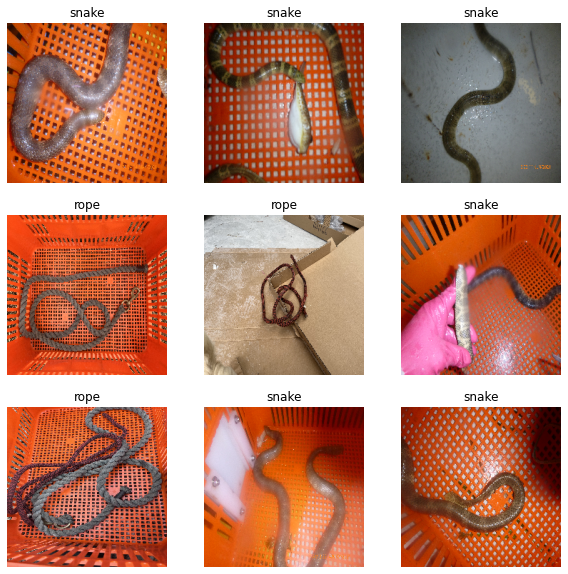

In [11]:
# We can have a look at the first 9 images from the training dataset: 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
# We will train a model using these datasets by passing them to Model.fit. We can also manually iterate over the 
# dataset and retreive batches on images:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
#installing the VGG16 convolutional base: 
conv_base = keras.applications.mobilenet_v2.MobileNetV2(
    weights="imagenet",  # Specifies the weight checkpoint from which to initiate the model 
    include_top=False,   # refers to including (or not) the densely connected classifier on top of the network. 
    input_shape=(224,224,3)) # The shape of the image tensors we'll feed to the network. This argument is optional

In [16]:
conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [17]:
def get_features_and_labels(dataset): 
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.mobilenet_v2.preprocess_input(images) 
        features = conv_base.predict(preprocessed_images) 
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_ds) 
val_features, val_labels = get_features_and_labels(val_ds) 
test_features, test_labels = get_features_and_labels(test_ds)

2022-01-28 11:22:36.585841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 3 of 1000
2022-01-28 11:22:46.728808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 14 of 1000
2022-01-28 11:22:56.323953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 24 of 1000
2022-01-28 11:23:06.453189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 35 of 1000
2022-01-28 11:23:16.437949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 46 of 1000
2022-01-28 11:23:26.638959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 57 of 1000
2022-01-28 11:23:36.630996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (

In [18]:
train_features.shape

(2951, 7, 7, 1280)

In [21]:
num_classes = len(class_names)

inputs = keras.Input(shape=(7,7,1280))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
X = layers.Dense(1, activation = "sigmoid")(x)
outputs = layers.Dense(num_classes)(x)
model = keras.Model(inputs, outputs)

In [25]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer = "adam",
             metrics = ["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "feature_extraction_mobilenetv2.keras",
        save_best_only = True,
        monitor = "val_loss")
]

epochs = 30

history = model.fit(
    train_features, train_labels,
    epochs = epochs,
    validation_data = (val_features, val_labels),
    callbacks = callbacks)

Epoch 1/30
 1/93 [..............................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2022-01-28 11:30:37.899700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


92/93 [============================>.] - ETA: 0s - loss: 0.0139 - accuracy: 0.9997

2022-01-28 11:30:43.220392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - 6s 66ms/step - loss: 0.0139 - accuracy: 0.9997 - val_loss: 0.7971 - val_accuracy: 0.9959
Epoch 2/30
93/93 [==============================] - 6s 64ms/step - loss: 0.1474 - accuracy: 0.9983 - val_loss: 1.0120 - val_accuracy: 0.9946
Epoch 3/30
93/93 [==============================] - 6s 63ms/step - loss: 0.0512 - accuracy: 0.9993 - val_loss: 1.0230 - val_accuracy: 0.9959
Epoch 4/30
93/93 [==============================] - 6s 64ms/step - loss: 0.4178 - accuracy: 0.9990 - val_loss: 1.5205 - val_accuracy: 0.9946
Epoch 5/30
93/93 [==============================] - 6s 64ms/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.9796 - val_accuracy: 0.9946
Epoch 6/30
93/93 [==============================] - 6s 64ms/step - loss: 0.0642 - accuracy: 0.9997 - val_loss: 4.6711 - val_accuracy: 0.9864
Epoch 7/30
93/93 [==============================] - 6s 64ms/step - loss: 0.8561 - accuracy: 0.9966 - val_loss: 0.8813 - val_accuracy: 0.9959
Epoch 8/30
93/93 [======

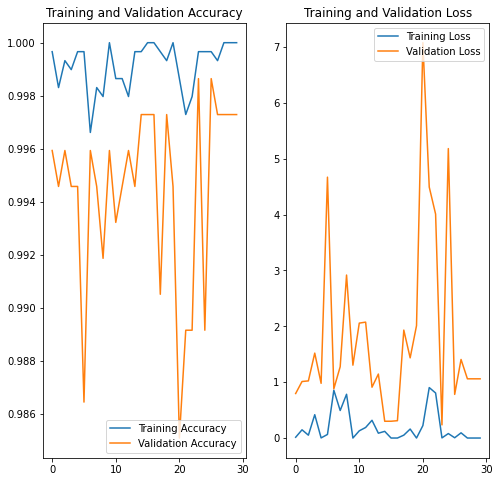

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
# Evaluate the model accuracy on test set 
test_model = keras.models.load_model(
            "feature_extraction_mobilenetv2.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels) 
print(f"Test accuracy: {test_acc:.3f}")

 3/14 [=====>........................] - ETA: 0s - loss: 24.5915 - accuracy: 0.9583

2022-01-28 11:33:43.674284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 41ms/step - loss: 10.9208 - accuracy: 0.9772
Test accuracy: 0.977
